In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os 

In [156]:
experiment_mapping = {
    2 : 'Text+BBox',
    3 : 'BBox',
    4 : 'Point+Text',
    5 : 'Point',
    6 : 'Text',
}

In [157]:
dir = 'ft_43_epochs'
files = os.listdir(dir)
files = [file for file in files if file.endswith('.csv')]

result_frame = []
counter = 0

for file in files:
    no_prefix = file.removeprefix('dice_scores_')
    experiment = no_prefix.split('_')[0]
    exp_nr = int(experiment[3])
    if exp_nr == 1:
        continue
    rotated = (experiment[4] == 'b')

    df = pd.read_csv(os.path.join(dir, file))
    df = df[df['Organ']!='Liver tumor']

    df['Rotated'] = [rotated for _ in range(len(df))]
    df['Experiment'] = [exp_nr for _ in range(len(df))]

    dataset_codes = ['0007', '0018', '0020', '0021', '0023']
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean([df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]))

    df['Score'] = scores 

    result_frame.append(df)

result_frame = pd.concat(result_frame)

/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/l

In [158]:
result_frame

,Organ,0007,0018,0020,0021,0023,Rotated,Experiment,Score
0,Aorta,0.034530,0.0,0.0,0.0,0.000000,True,6,0.034530
1,Colon cancer,0.000000,0.0,0.0,0.0,0.000000,True,6,NaN
2,Esophagus,0.000000,0.0,0.0,0.0,0.000000,True,6,NaN
3,Gallbladder,0.000000,0.0,0.0,0.0,0.000000,True,6,NaN
4,Inferior vena cava,0.026020,0.0,0.0,0.0,0.000000,True,6,0.026020
...,...,...,...,...,...,...,...,...,...
11,Portal/splenic vein,0.083825,0.0,0.0,0.0,0.000000,True,5,0.083825
12,Right adrenal gland,0.133221,0.0,0.0,0.0,0.000000,True,5,0.133221
13,Right kidney,0.344319,0.0,0.0,0.0,0.000000,True,5,0.344319
14,Spleen,0.385779,0.0,0.0,0.0,0.376665,True,5,0.381222


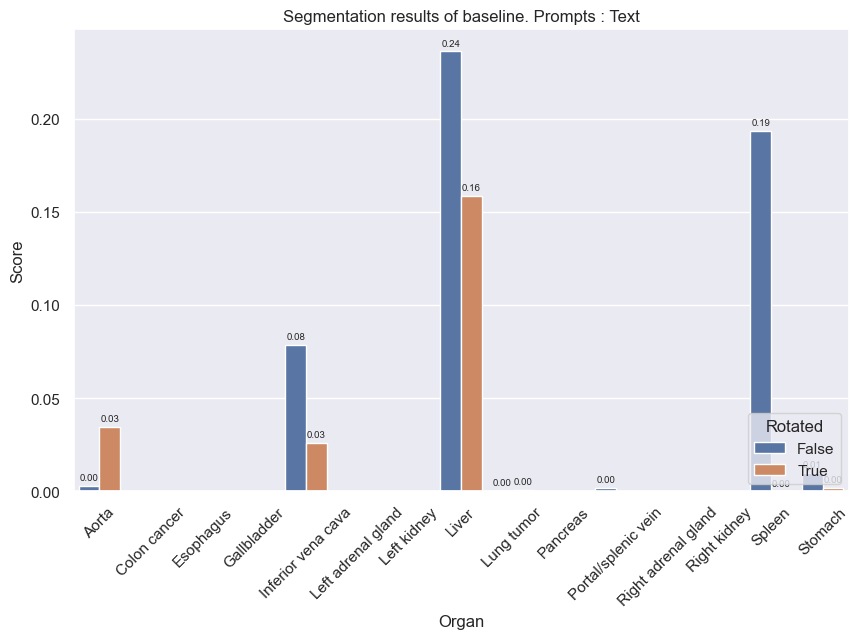

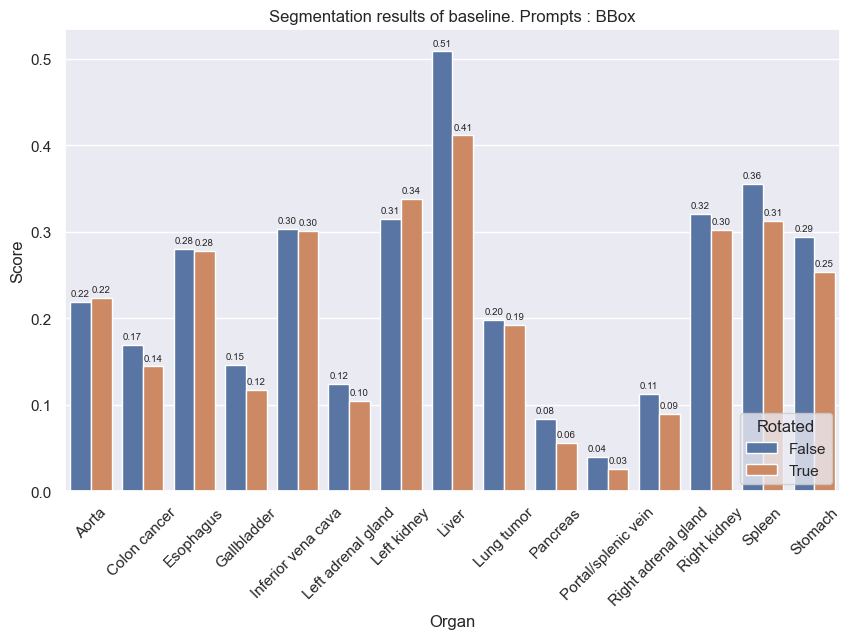

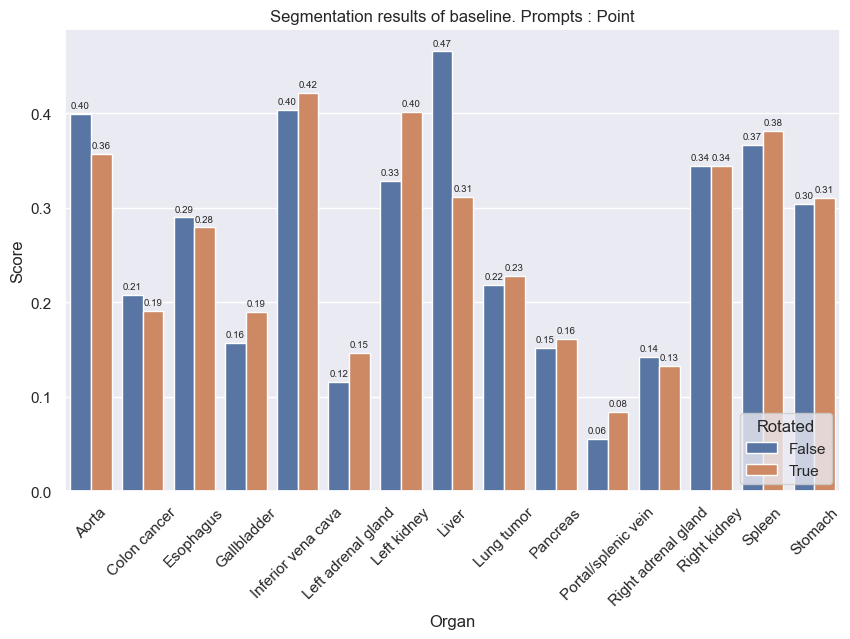

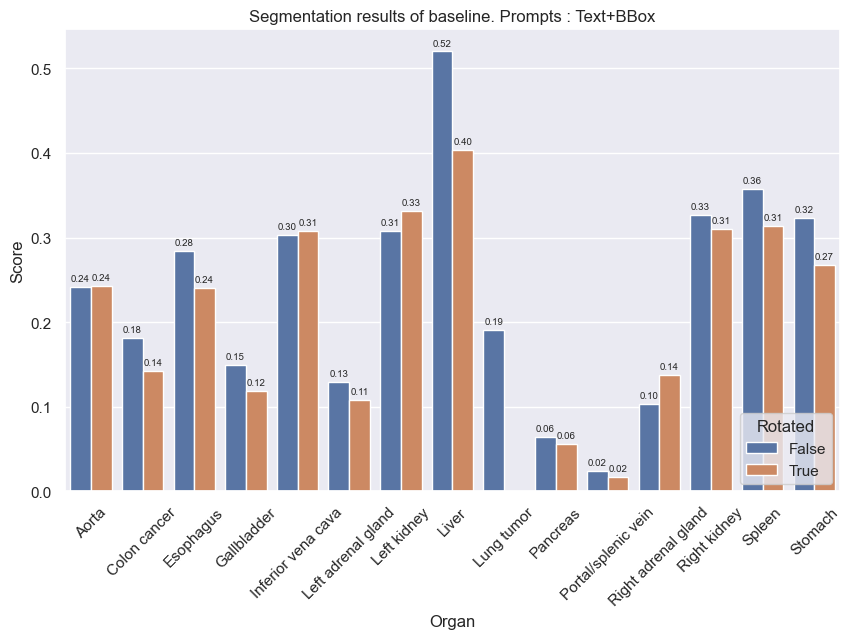

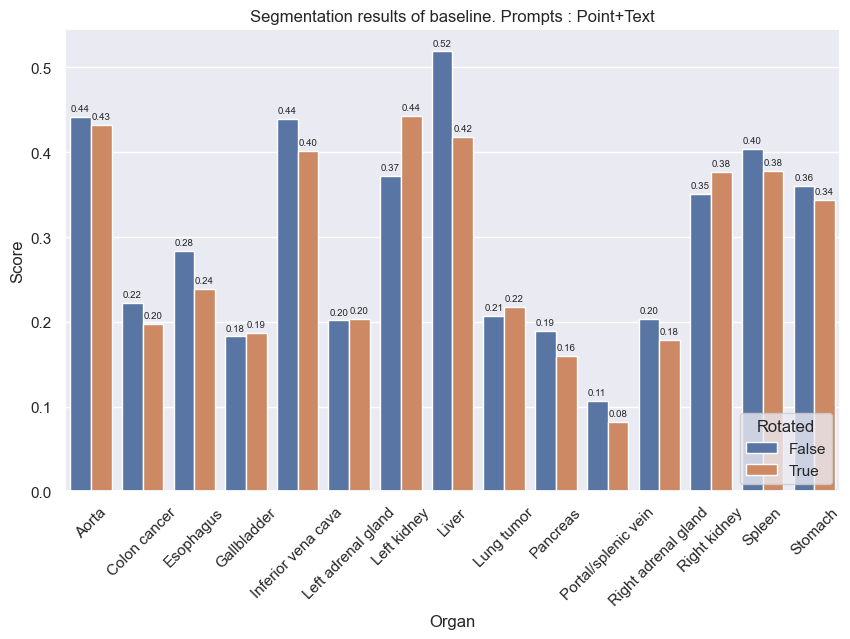

In [159]:
for experiment in result_frame['Experiment'].unique():
    subset = result_frame[result_frame['Experiment'] == experiment].copy()
    subset = subset.reset_index()

    sns.set_theme()
    plt.figure(figsize=(10, 6))
    plot = sns.barplot(x='Organ', y='Score', hue='Rotated', data=subset)
    plt.xticks(rotation=45)
    plt.legend(title=f'Rotated', loc='lower right')
    for p in plot.patches:
        if p.get_height() == 0:
            continue
        plot.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 6), 
                    textcoords = 'offset points',
                    fontsize=7)
    
    plt.title(f'Segmentation results of baseline. Prompts : {experiment_mapping[experiment]}')
    plt.xlabel('Organ')
    plt.ylabel('Score')
    plt.show()
    